# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name: Josh Cubero


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
import keras.backend as K
from keras.datasets import cifar10
from keras.optimizers import Adam,SGD,RMSprop
from sklearn.model_selection import train_test_split
### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    y = y.reshape(-1)
    return np.eye(num_class)[y]
y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [3]:
print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [4]:
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train_vec, test_size=0.2, random_state=42)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(4,4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 activation_5 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

In [5]:
#This cell creates several optimizer objects for hyperparameter tuning.

In [6]:
adam = Adam(learning_rate=0.00001)
sgd = SGD(learning_rate=0.1)
rms = RMSprop(learning_rate=0.1)

In [ ]:
# Define model optimizer and loss function
model.compile(loss='binary_crossentropy',optimizer=adam,metrics='accuracy')

In [7]:
# This is the first iteration of this CNN and uses the Adam optimizer with the learning rate set to 0.00001.
# Additionally, the batch size is set to 64. This model was compiled 15-20 for hyperparameter tuning.
# The model seen here was most optimized for this study.

In [ ]:
# Train the model and store model parameters/loss values
model.fit(x = x_tr,y=y_tr,epochs=60,batch_size=64, validation_data=(x_val,y_val))

Epoch 1/60
625/625 [==============================] - 4s 5ms/step - loss: 1.8669 - accuracy: 0.1547 - val_loss: 0.8577 - val_accuracy: 0.2117
Epoch 2/60
625/625 [==============================] - 3s 4ms/step - loss: 0.7231 - accuracy: 0.2423 - val_loss: 0.6368 - val_accuracy: 0.2570
Epoch 3/60
625/625 [==============================] - 4s 6ms/step - loss: 0.5721 - accuracy: 0.2858 - val_loss: 0.5328 - val_accuracy: 0.2893
Epoch 4/60
625/625 [==============================] - 4s 7ms/step - loss: 0.4926 - accuracy: 0.3115 - val_loss: 0.4752 - val_accuracy: 0.3092
Epoch 5/60
625/625 [==============================] - 7s 12ms/step - loss: 0.4417 - accuracy: 0.3363 - val_loss: 0.4277 - val_accuracy: 0.3325
Epoch 6/60
625/625 [==============================] - 4s 6ms/step - loss: 0.4017 - accuracy: 0.3569 - val_loss: 0.3987 - val_accuracy: 0.3511
Epoch 7/60
625/625 [==============================] - 3s 4ms/step - loss: 0.3734 - accuracy: 0.3747 - val_loss: 0.3745 - val_accuracy: 0.3625
Epoch

## 3. Plot the training and validation loss curve versus epochs. (5 points)

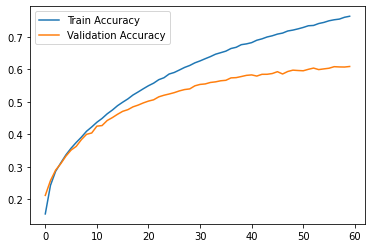

In [ ]:
# Plot the loss curve
import pandas as pd
losses = pd.DataFrame(model.history.history)
plt.plot(losses['accuracy'],label='Train Accuracy')
plt.plot(losses['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [8]:
# Above, the model's accuracy is plotted. The train accuracy steadily improves, while the validation accuracy remains flat.
# This indicates that the model is overfitting and will need more work on the data layers to reduce overfitting.

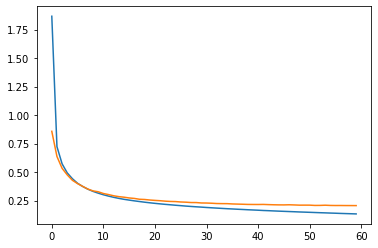

In [ ]:
plt.plot(losses['loss'],label='Training Loss')
plt.plot(losses['val_loss'],label='Validation Loss')

In [9]:
# Once again, we see that the validation and training data appear to diverge, which further supports the idea that 
# the model is experiencing overfitting.

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [ ]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model.compile(optimizer=adam,loss='binary_crossentropy',metrics='accuracy')

In [ ]:
#<Train your model on the entire training set (50K samples)>
model.fit(x=x_train,y=y_train_vec,epochs=60,batch_size=64,validation_data=(x_test,y_test_vec))

Epoch 1/60
782/782 [==============================] - 5s 5ms/step - loss: 0.7155 - accuracy: 0.2381 - val_loss: 0.4548 - val_accuracy: 0.2826
Epoch 2/60
782/782 [==============================] - 5s 6ms/step - loss: 0.4045 - accuracy: 0.3124 - val_loss: 0.3750 - val_accuracy: 0.3323
Epoch 3/60
782/782 [==============================] - 4s 5ms/step - loss: 0.3466 - accuracy: 0.3495 - val_loss: 0.3358 - val_accuracy: 0.3632
Epoch 4/60
782/782 [==============================] - 4s 5ms/step - loss: 0.3147 - accuracy: 0.3777 - val_loss: 0.3111 - val_accuracy: 0.3855
Epoch 5/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2929 - accuracy: 0.4024 - val_loss: 0.2940 - val_accuracy: 0.4034
Epoch 6/60
782/782 [==============================] - 4s 6ms/step - loss: 0.2769 - accuracy: 0.4265 - val_loss: 0.2797 - val_accuracy: 0.4268
Epoch 7/60
782/782 [==============================] - 4s 5ms/step - loss: 0.2641 - accuracy: 0.4476 - val_loss: 0.2693 - val_accuracy: 0.4415
Epoch 

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [ ]:
# Evaluate your model performance (testing accuracy) on testing data.
acc_score = model.evaluate(x_test,y_test_vec)

313/313 [==============================] - 1s 4ms/step - loss: 0.1901 - accuracy: 0.6540


In [10]:
# The model trained on the entire dataset returned 65% accuracy, which isn't terrible for a model where only the 
# hyperparameters have been tuned. Next, the study will add Batch Normalization and Dropout layers to reduce overfitting.

## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

In [15]:
# Next,this study experimented with 15-20 variations of layers, where the dropout and batch normalization layers are 
# repositioned to see which version is most efficient.

In [ ]:
from keras.layers import Dropout
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))
model.add(Conv2D(64,kernel_size=(4,4)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer=adam,loss='binary_crossentropy',metrics='accuracy')

In [ ]:
model.fit(x=x_train,y=y_train_vec,epochs=60,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/60
782/782 [==============================] - 6s 7ms/step - loss: 0.4790 - accuracy: 0.1945 - val_loss: 0.3530 - val_accuracy: 0.1913
Epoch 2/60
782/782 [==============================] - 5s 7ms/step - loss: 0.3362 - accuracy: 0.2808 - val_loss: 0.3184 - val_accuracy: 0.2090
Epoch 3/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2953 - accuracy: 0.3328 - val_loss: 0.3033 - val_accuracy: 0.2198
Epoch 4/60
782/782 [==============================] - 5s 7ms/step - loss: 0.2741 - accuracy: 0.3786 - val_loss: 0.2990 - val_accuracy: 0.2436
Epoch 5/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2605 - accuracy: 0.4054 - val_loss: 0.2911 - val_accuracy: 0.2731
Epoch 6/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2510 - accuracy: 0.4258 - val_loss: 0.2822 - val_accuracy: 0.3085
Epoch 7/60
782/782 [==============================] - 5s 7ms/step - loss: 0.2437 - accuracy: 0.4455 - val_loss: 0.2855 - val_accuracy: 0.3126
Epoch 

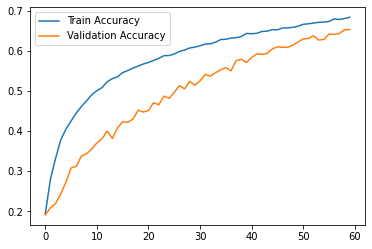

In [ ]:
import pandas as pd
losses = pd.DataFrame(model.history.history)
plt.plot(losses['accuracy'],label='Train Accuracy')
plt.plot(losses['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [13]:
# The addition of batch normalization and dropout layers returned immediate improvement of the initial model.

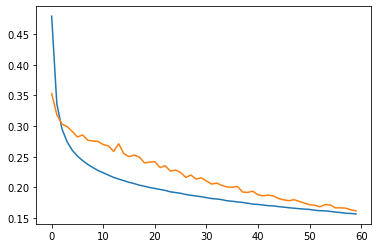

In [ ]:
plt.plot(losses['loss'],label='Training Loss')
plt.plot(losses['val_loss'],label='Validation Loss')

In [14]:
#Above we can see that the validation loss and training loss converge much more efficiently than the initial model.

In [ ]:
from keras.layers import Dropout
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.5))
model.add(Conv2D(64,kernel_size=(4,4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer=adam,loss='binary_crossentropy',metrics='accuracy')

In [ ]:
model.fit(x=x_train,y=y_train_vec,epochs=60,batch_size=64,validation_data=(x_test,y_test_vec))

Epoch 1/60
782/782 [==============================] - 6s 7ms/step - loss: 0.4221 - accuracy: 0.2464 - val_loss: 0.3736 - val_accuracy: 0.4035
Epoch 2/60
782/782 [==============================] - 6s 7ms/step - loss: 0.3041 - accuracy: 0.3360 - val_loss: 0.3125 - val_accuracy: 0.4442
Epoch 3/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2716 - accuracy: 0.3897 - val_loss: 0.2840 - val_accuracy: 0.4666
Epoch 4/60
782/782 [==============================] - 5s 7ms/step - loss: 0.2555 - accuracy: 0.4190 - val_loss: 0.2661 - val_accuracy: 0.4833
Epoch 5/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2452 - accuracy: 0.4441 - val_loss: 0.2547 - val_accuracy: 0.5003
Epoch 6/60
782/782 [==============================] - 5s 6ms/step - loss: 0.2380 - accuracy: 0.4615 - val_loss: 0.2464 - val_accuracy: 0.5118
Epoch 7/60
782/782 [==============================] - 6s 7ms/step - loss: 0.2321 - accuracy: 0.4765 - val_loss: 0.2394 - val_accuracy: 0.5259
Epoch 

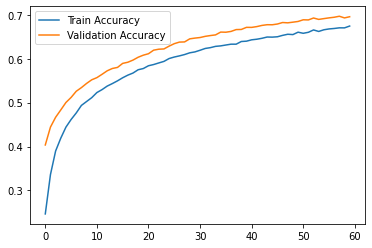

In [ ]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['accuracy'],label='Train Accuracy')
plt.plot(losses['val_accuracy'],label='Validation Accuracy')
plt.legend()

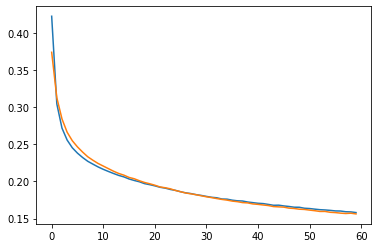

In [ ]:
plt.plot(losses['loss'],label='Training Loss')
plt.plot(losses['val_loss'],label='Validation Loss')

In [17]:
# Evaluate your model performance (testing accuracy) on testing data. Here, the validation accuracy is ~69% and the 
# training accuracy is ~67%. This indicates that the model is generalizing quite well. Additonally, the validation and 
# training loss are nearly identical which suggests that the model is not overfitting.
acc_score = model.evaluate(x_test,y_test_vec)

In [ ]:
"""from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split=0.2
)

datagen.fit(x_tr)

train_generator = datagen.flow(x_tr,y_tr,batch_size=60,subset='training')
validation_generator = datagen.flow(x_tr,y_tr,batch_size=60,subset='validation')

history = model.fit_generator( generator=train_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=True,
                              steps_per_epoch=len(train_generator)/60,
                              validation_steps=len(validation_generator)/60,
                              epochs = 60,
                              workers = -1)"""

"from keras.preprocessing.image import ImageDataGenerator\ndatagen = ImageDataGenerator(\n    featurewise_center=True,\n    featurewise_std_normalization=True,\n    rotation_range=10,\n    fill_mode='nearest',\n    validation_split=0.2\n)\n\ndatagen.fit(x_tr)\n\ntrain_generator = datagen.flow(x_tr,y_tr,batch_size=60,subset='training')\nvalidation_generator = datagen.flow(x_tr,y_tr,batch_size=60,subset='validation')\n\nhistory = model.fit_generator( generator=train_generator,\n                              validation_data=validation_generator,\n                              use_multiprocessing=True,\n                              steps_per_epoch=len(train_generator)/60,\n                              validation_steps=len(validation_generator)/60,\n                              epochs = 60,\n                              workers = -1)"

In [6]:
from keras.layers import Dropout
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.5))
model.add(Conv2D(64,kernel_size=(4,4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [7]:
model.compile(optimizer=adam,loss='binary_crossentropy',metrics='accuracy')

In [8]:
model.fit(x=x_train,y=y_train_vec,epochs=100,batch_size=64,validation_data=(x_test,y_test_vec))

Epoch 1/100
782/782 [==============================] - 15s 7ms/step - loss: 0.6429 - accuracy: 0.1779 - val_loss: 0.5278 - val_accuracy: 0.3139
Epoch 2/100
782/782 [==============================] - 5s 6ms/step - loss: 0.4452 - accuracy: 0.2492 - val_loss: 0.4143 - val_accuracy: 0.3804
Epoch 3/100
782/782 [==============================] - 5s 6ms/step - loss: 0.3490 - accuracy: 0.3067 - val_loss: 0.3462 - val_accuracy: 0.4185
Epoch 4/100
782/782 [==============================] - 5s 6ms/step - loss: 0.3006 - accuracy: 0.3529 - val_loss: 0.3072 - val_accuracy: 0.4481
Epoch 5/100
782/782 [==============================] - 4s 6ms/step - loss: 0.2735 - accuracy: 0.3911 - val_loss: 0.2809 - val_accuracy: 0.4663
Epoch 6/100
782/782 [==============================] - 5s 6ms/step - loss: 0.2585 - accuracy: 0.4218 - val_loss: 0.2650 - val_accuracy: 0.4841
Epoch 7/100
782/782 [==============================] - 4s 6ms/step - loss: 0.2482 - accuracy: 0.4403 - val_loss: 0.2538 - val_accuracy: 0.495

In [18]:
# This iteration of the model completes 100 epochs and returns training accuracy of ~71% and validation accuracy of ~72%, 
# which further displays a model that is generalizing well and is not overfitting.

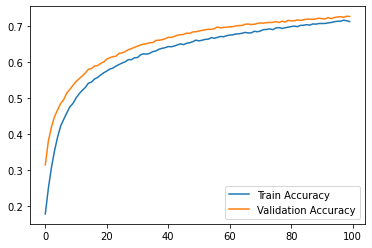

In [10]:
import pandas as pd
losses = pd.DataFrame(model.history.history)
plt.plot(losses['accuracy'],label='Train Accuracy')
plt.plot(losses['val_accuracy'],label='Validation Accuracy')
plt.legend()

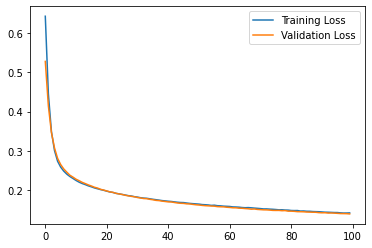

In [13]:
plt.plot(losses['loss'],label='Training Loss')
plt.plot(losses['val_loss'],label='Validation Loss')
plt.legend()

In [12]:
acc_score = model.evaluate(x_test,y_test_vec)

313/313 [==============================] - 1s 3ms/step - loss: 0.1392 - accuracy: 0.7256


In [43]:
from keras.layers import Dropout
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.5))
model.add(Conv2D(64,kernel_size=(4,4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [44]:
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics='accuracy')

In [45]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)

model.fit(datagen.flow(x_train, y_train_vec, batch_size=64), epochs=60,validation_data=(x_test,y_test_vec))



Epoch 1/60
782/782 [==============================] - 41s 52ms/step - loss: 2.0990 - accuracy: 0.2486 - val_loss: 1.7588 - val_accuracy: 0.3765
Epoch 2/60
782/782 [==============================] - 42s 54ms/step - loss: 1.9252 - accuracy: 0.3032 - val_loss: 1.6656 - val_accuracy: 0.4112
Epoch 3/60
782/782 [==============================] - 41s 52ms/step - loss: 1.8626 - accuracy: 0.3260 - val_loss: 1.6054 - val_accuracy: 0.4308
Epoch 4/60
782/782 [==============================] - 41s 52ms/step - loss: 1.8181 - accuracy: 0.3418 - val_loss: 1.5669 - val_accuracy: 0.4416
Epoch 5/60
782/782 [==============================] - 41s 52ms/step - loss: 1.7887 - accuracy: 0.3497 - val_loss: 1.5429 - val_accuracy: 0.4524
Epoch 6/60
782/782 [==============================] - 42s 53ms/step - loss: 1.7527 - accuracy: 0.3628 - val_loss: 1.5093 - val_accuracy: 0.4599
Epoch 7/60
782/782 [==============================] - 40s 51ms/step - loss: 1.7268 - accuracy: 0.3736 - val_loss: 1.4878 - val_accuracy:

In [49]:
#The last model test included data augmentation. The data augmentation model failed to outperform the model that incoroporated
#batch normalization and drop out layers. 

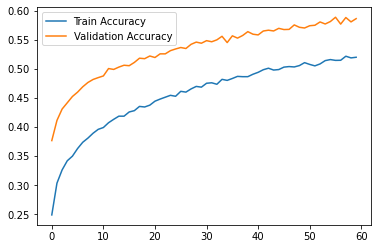

In [47]:
import pandas as pd
losses = pd.DataFrame(model.history.history)
plt.plot(losses['accuracy'],label='Train Accuracy')
plt.plot(losses['val_accuracy'],label='Validation Accuracy')
plt.legend()

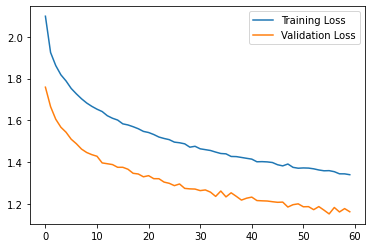

In [48]:
plt.plot(losses['loss'],label='Training Loss')
plt.plot(losses['val_loss'],label='Validation Loss')
plt.legend()